OCI OpenSearch Service sample notebook.

Copyright (c) 2024 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License (UPL) v 1.0](https://oss.oracle.com/licenses/upl/).

### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

## Multimodal/Visual Search pipeline with OCI OpenSearch and Contrasive Language-Image Pretraining - CLIP.

This Notebook demonstrates a **semantic image search / visual search pipeline** using **CLIP (Contrastive Language-Image Pretraining)** and **OpenSearch**. The pipeline processes images from **CIFAR-10** or **FASHION TRENDS (LOCAL)**, extracts embeddings using a pre-trained CLIP model, and indexes them into OpenSearch for efficient similarity search. Users can input a **text query** to retrieve and visualize the most relevant images based on semantic similarity. The notebook supports batch processing, efficient indexing, and dynamic dataset selection, making it scalable for large-scale image retrieval applications.

### Prerequisites
-  OCI OpenSearch with version 2.11 or above. If you do not already have navigate to the documentation to  [Create an OpenSearch Cluster](https://docs.oracle.com/en/learn/oci-opensearch/index.html#task-1-create-an-oci-search-service-cluster).

To learn more about how CLIP model works for visual search, please refer to the [CLIP GitHub Repo](https://github.com/openai/CLIP). You can also learn more from the research paper on [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)

In this Visula Search /Multimodal Search Pipeline, we will be using the popular and publicly available datasets [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) and  [FASHION_TRENDS](data/fashion_trends) and  dataset to perform visual search using CLIP and OCI OpenSearch

### 1- Install dependencies in your environment


In [103]:
!pip install -U langchain langchain-community opensearch-py pypdf  sentence-transformers oci  langchain-huggingface oracle_ads transformers datasets pillow rich torch torchvision matplotlib tqdm requests beautifulsoup4 pandas selenium webdriver-manager undetected-chromedriver


  Using cached matplotlib-3.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)


### 2- Import all relevant Libraries and Modules


In [286]:
from opensearchpy import OpenSearch, helpers, RequestsHttpConnection
from typing import List, Dict
import sys
import re
from bs4 import BeautifulSoup
import oci
from transformers import CLIPProcessor, CLIPModel
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from opensearchpy import OpenSearch
from tqdm import tqdm
from PIL import Image
import json
import random
from torchvision import datasets, transforms

import config as config 
import scrape_products as scrape_products
from config import OPENSEARCH_USERNAME,OPENSEARCH_PASSWORD,COMPARTMENT_ID,OPENSEARCH_HOST,OPENSEARCH_URL,OPENSEARCH_PORT
import importlib

import pandas as pd
import requests
from io import BytesIO
import random
import utils as utils

importlib.reload(config)
importlib.reload(utils)

<module 'utils' from '/home/datascience/image_search/utils.py'>

### 3- Define Key Variables, Connect to OpenSearch and test Connection


In [390]:
# --- Configuration ---
PRODUCT_INDEX_NAME = INDEX_NAME = "fashion_products_clip"
CIFAR10_INDEX_NAME = "cifar10_clip_1"
CIFAR10_DATASET_NAME="CIFAR-10"
PRODUCT_DATASET_NAME="FASHION_TRENDS"
BATCH_SIZE = 50  
signer = oci.auth.signers.get_resource_principals_signer()

In [321]:
#Connect To OpenSearch
from opensearchpy import OpenSearch
importlib.reload(config)
opensearchClient = OpenSearch(
        hosts=[{'host': config.OPENSEARCH_HOST, 'port': config.OPENSEARCH_PORT}],
        http_compress=True,  
        http_auth=(config.OPENSEARCH_USERNAME, config.OPENSEARCH_PASSWORD),
        ssl_assert_hostname=False,
        ssl_show_warn=False,
        use_ssl=False,
        auth_type=config.AUTH_TYPE,
        timeout=10,
        verify_certs=False,
        scheme='https'
    )

In [322]:
# Test OpenSearch Connection by Checking the Cluster Settings configure Cluster Settings
print("*******Step 1 configure Cluster Settings******")
response = opensearchClient.transport.perform_request('PUT', "/_cluster/settings", body=config.CLUSTER_CONFIG);
print(response);

*******Step 1 configure Cluster Settings******
{'acknowledged': True, 'persistent': {'plugins': {'ml_commons': {'rag_pipeline_feature_enabled': 'true', 'memory_feature_enabled': 'true', 'only_run_on_ml_node': 'false', 'model_access_control_enabled': 'true', 'native_memory_threshold': '99', 'allow_registering_model_via_local_file': 'true', 'model_auto_redeploy': {'lifetime_retry_times': '10', 'enable': 'true'}, 'allow_registering_model_via_url': 'true'}}}, 'transient': {}}


In [362]:
print(opensearchClient.indices.exists(index=PRODUCT_INDEX_NAME))

False


### 4- Create Index in OpenSearch to store image embeddings

In [363]:
importlib.reload(config)
def create_index(index_name):
    """
    Check if the OpenSearch index exists, and create it if it doesn't.
    """
    if not opensearchClient.indices.exists(index=index_name):
        index_body=config.INDEX_BODY
        if "product" in index_name:
            index_body=config.INDEX_BODY_PRODUCT
            
        print(f"INDEX BODY:\n\n {index_body}\n\n")
        opensearchClient.indices.create(index=index_name, body=index_body)
        print(f"Successfully Created  {index_name} INDEX!!!!")
    else:
        dest_index_mapping = opensearchClient.indices.get_mapping(index=index_name)
        dest_index_fields = dest_index_mapping[index_name]["mappings"]["properties"]
        print(f"{index_name} index already exists!")
        print(f"INDEX FIELDS:\n\n {dest_index_fields}")


In [364]:
#create CIFAR 10 Index
create_index(CIFAR10_INDEX_NAME)

cifar10_clip_1 index already exists!
INDEX FIELDS:

 {'embedding': {'type': 'knn_vector', 'dimension': 512, 'method': {'engine': 'lucene', 'space_type': 'cosinesimil', 'name': 'hnsw', 'parameters': {}}}, 'image_id': {'type': 'keyword'}}


In [365]:
#Create FASHION TRENDS  Index in OpenSearch 
create_index(PRODUCT_INDEX_NAME)

INDEX BODY:

 {'settings': {'index': {'knn': True, 'number_of_shards': 1, 'number_of_replicas': 0}}, 'mappings': {'properties': {'product_id': {'type': 'keyword'}, 'product_title': {'type': 'text'}, 'category': {'type': 'keyword'}, 'image_url': {'type': 'keyword'}, 'embedding': {'type': 'knn_vector', 'dimension': 512, 'method': {'name': 'hnsw', 'engine': 'lucene', 'space_type': 'cosinesimil'}}}}}


Successfully Created  fashion_products_clip_1 INDEX!!!!


### 5- Define Utility methods Load, Transform and Visualize the Dataset Before Processing 

- Download the Datasets of Interest. You do not have to use both or either of the CIFAR-10 and the local fashion trends datasets used in this experiment. One is sufficient for this experiment). You can also replace the fashion trends dataset with your own '

- Load & Transform the data 

- Visualize the Dataset

In [366]:
def get_transform(sizeX=224, sizeY=224):
    return transforms.Compose([
        transforms.Resize((sizeX, sizeY)),
        transforms.ToTensor()
    ])

In [367]:
def load_dataset(dataset_name=CIFAR10_DATASET_NAME, resizeX=224, resizeY=224,local_data_path="data/fashion_trends/"):
    print(f"..................LOADING {dataset_name.upper()} IMAGE DATASET.....................")

    transform = get_transform(sizeX=resizeX, sizeY=resizeY)

    if dataset_name == CIFAR10_DATASET_NAME:
        return datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    
    elif os.path.exists(local_data_path) and len(os.listdir(local_data_path)) > 0:
        print(f"Loading images from {local_data_path}...")
        return utils.LocalImageDataset(local_data_path, transform=transform)

    else:
        raise ValueError(f"Dataset '{dataset_name}' not found! Ensure '{local_data_path}' exists and contains images.")


In [368]:
# Visualize the dataset
def display_random_images_per_class(dataset, dataset_name,num_images_per_class=10, imageSize=(20,20)):
    rows=min(len(dataset.classes),10)
    class_dict = {label: [] for label in range(rows)}
    
    # Collect 10 random images per class
    for idx in range(len(dataset)):
        image, label = dataset[idx]
        if len(class_dict[label]) < num_images_per_class:
            class_dict[label].append(image)
        if all(len(images) == num_images_per_class for images in class_dict.values()):
            break
    
    fig, axes = plt.subplots(rows, num_images_per_class + 1, figsize=imageSize)
    classes = dataset.classes
    
    for row, (label, images) in enumerate(class_dict.items()):
        axes[row, 0].text(0.5, 0.5, classes[label], fontsize=10, ha='center', va='center', weight='bold')
        axes[row, 0].axis("off")
        
        for col, image in enumerate(images):
            axes[row, col + 1].imshow(image.permute(1, 2, 0).numpy().clip(0, 1))
            axes[row, col + 1].axis("off")
    
    plt.suptitle(f"Random Images from Each {dataset_name} Class", fontsize=16)
    plt.show()


..................LOADING FASHION_TRENDS IMAGE DATASET.....................
Loading images from data/fashion_trends/...
------------Random Image Sample Visualization from the FASHION_TRENDS------------


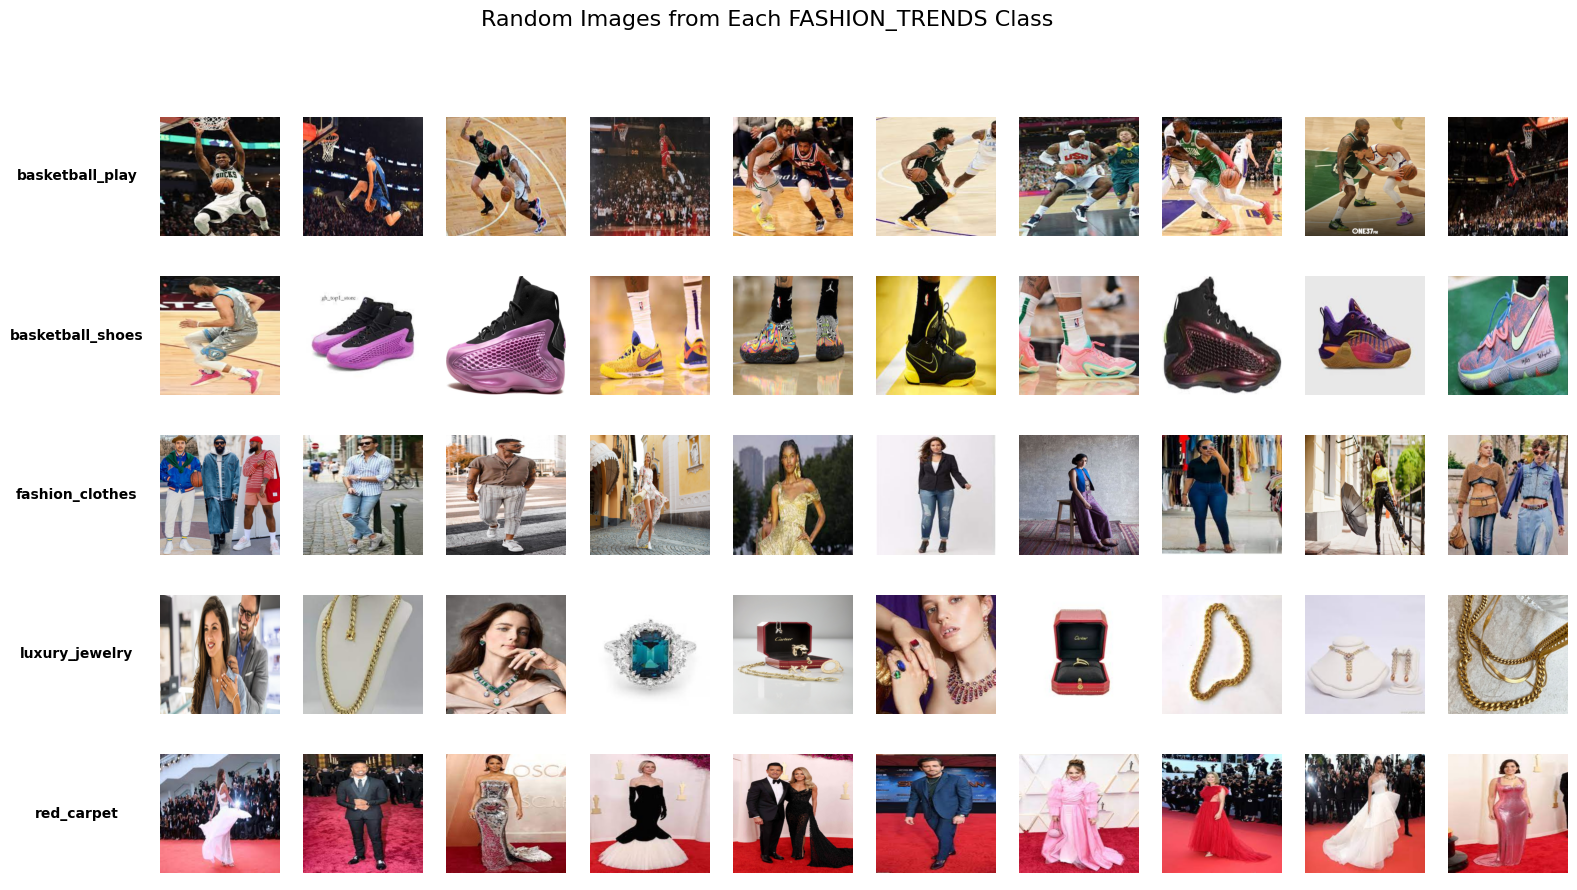

In [369]:
#Load and visualize FASHION TRENDS DataSet
fashion_trends_dataset=load_dataset(dataset_name=PRODUCT_DATASET_NAME,resizeX=448, resizeY=448, local_data_path="data/fashion_trends/")
print(f"------------Random Image Sample Visualization from the {PRODUCT_DATASET_NAME}------------")
display_random_images_per_class(dataset=fashion_trends_dataset, dataset_name=PRODUCT_DATASET_NAME,num_images_per_class=10, imageSize=(20,10))

..................LOADING CIFAR-10 IMAGE DATASET.....................
------------Random Image Sample Visualization from the CIFAR-10------------


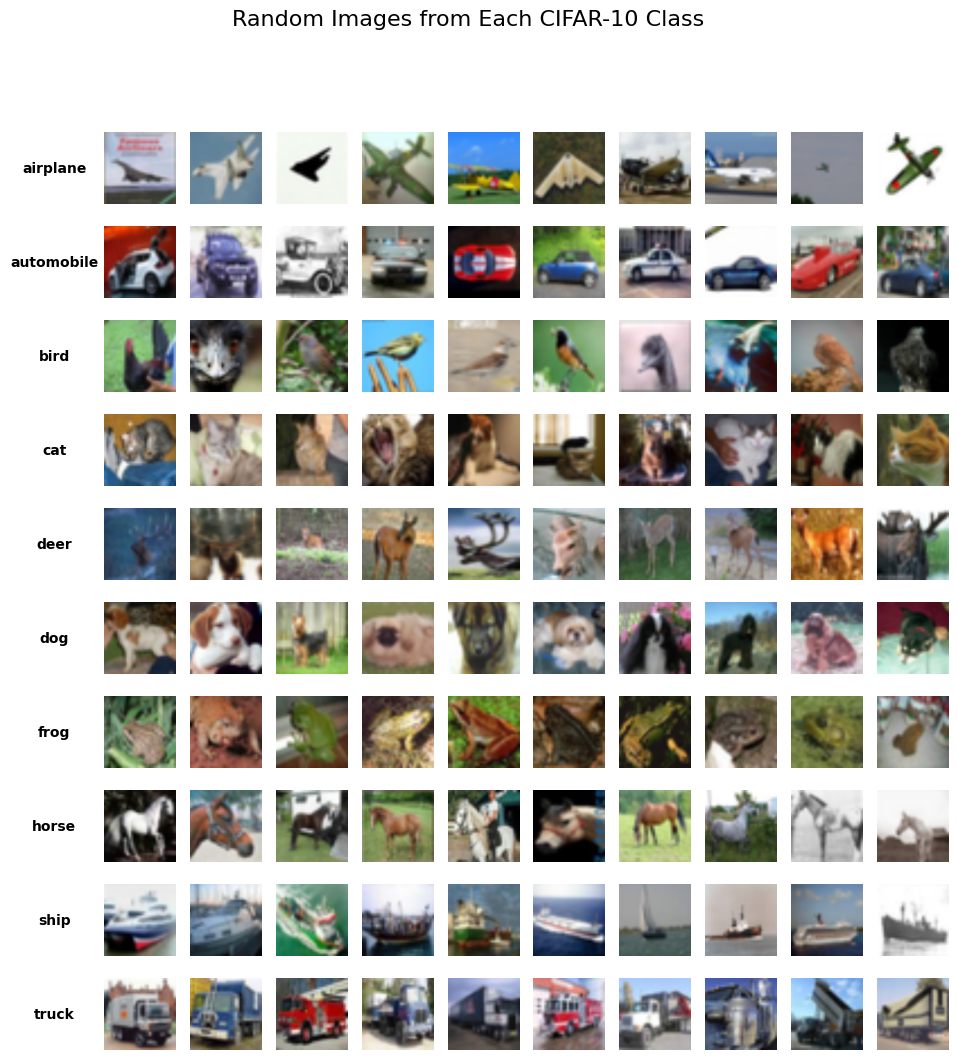

In [331]:
#Load and visualize CIFAR-10 DataSet
cifar10_dataset=load_dataset(dataset_name=CIFAR10_DATASET_NAME)
print(f"------------Random Image Sample Visualization from the {CIFAR10_DATASET_NAME}------------")
display_random_images_per_class(dataset=cifar10_dataset, dataset_name=CIFAR10_DATASET_NAME,num_images_per_class=10, imageSize=(12,12))


### 6- Define Utility methods to Load CLIP model, Process and Ingest the datasets in batches 

- Load model to device

- Extract relevant features from images using the CLIP model to generate Image embeddings

- Ingest the Image Embedding data into OCI OpenSearch using Batch Processing

- Process and ingest data in batches for optimal memory utilization. Loading all the dataset into memory and then ingesting could consume a lot of your available memory.

In [370]:
# Load CLIP model from SentenceTransformers
def load_model():
    print(f"..................LOADING CLIP MODEL.....................")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model= SentenceTransformer("clip-ViT-B-32").to(device)
    print(f"CLIP MODEL successfully loaded on: {device} device")
    return model, device


In [371]:
CLIP_MODEL, device = load_model()

..................LOADING CLIP MODEL.....................
CLIP MODEL successfully loaded on: cpu device


In [372]:
# Process images in batches extracting image features, generating image embeddings and indexing them directly into OpenSearch
def process_and_index_images_features(model, dataset, index_name, batch_size=32):
    print(f"..................BATCH INGEST SEARCHABLE IMAGES INTO OPENSEARCH.....................")
    for i in tqdm(range(0, len(dataset), batch_size)):
        print(f"NOW PROCESSING BATCH: {i} ...")
        batch_images = [transforms.ToPILImage()(dataset[j][0]) for j in range(i, min(i+batch_size, len(dataset)))]
        batch_features = model.encode(batch_images, convert_to_tensor=True).cpu().numpy()
        
        batch_docs = [
            {"image_id": str(j), "embedding": batch_features[idx].tolist()}
            for idx, j in enumerate(range(i, min(i+batch_size, len(dataset))))
        ]
        
        for doc in batch_docs:
            opensearchClient.index(index=index_name, body=doc)

In [373]:
#Process and Index the FASHION TRENDS Dataset
process_and_index_images_features(model=CLIP_MODEL,dataset=fashion_trends_dataset, index_name=PRODUCT_INDEX_NAME, batch_size=128)

..................BATCH INGEST SEARCHABLE IMAGES INTO OPENSEARCH.....................


  0%|          | 0/2 [00:00<?, ?it/s]

NOW PROCESSING BATCH: 0 ...


 50%|█████     | 1/2 [00:08<00:08,  8.68s/it]

NOW PROCESSING BATCH: 128 ...


100%|██████████| 2/2 [00:15<00:00,  7.72s/it]


In [332]:
#Process and Index CIFAR-10 Dataset
process_and_index_images_features(CLIP_MODEL,cifar10_dataset, CIFAR10_INDEX_NAME, batch_size=128)

..................BATCH INGEST SEARCHABLE IMAGES INTO OPENSEARCH.....................


  0%|          | 0/79 [00:00<?, ?it/s]

NOW PROCESSING BATCH: 0 ...


  1%|▏         | 1/79 [00:06<08:10,  6.29s/it]

NOW PROCESSING BATCH: 128 ...


  3%|▎         | 2/79 [00:12<07:46,  6.06s/it]

NOW PROCESSING BATCH: 256 ...


  4%|▍         | 3/79 [00:18<07:45,  6.13s/it]

NOW PROCESSING BATCH: 384 ...


  5%|▌         | 4/79 [00:24<07:40,  6.14s/it]

NOW PROCESSING BATCH: 512 ...


  6%|▋         | 5/79 [00:30<07:34,  6.14s/it]

NOW PROCESSING BATCH: 640 ...


  8%|▊         | 6/79 [00:36<07:27,  6.13s/it]

NOW PROCESSING BATCH: 768 ...


  9%|▉         | 7/79 [00:42<07:16,  6.07s/it]

NOW PROCESSING BATCH: 896 ...


 10%|█         | 8/79 [00:48<07:11,  6.07s/it]

NOW PROCESSING BATCH: 1024 ...


 11%|█▏        | 9/79 [00:54<07:06,  6.09s/it]

NOW PROCESSING BATCH: 1152 ...


 13%|█▎        | 10/79 [01:01<07:00,  6.10s/it]

NOW PROCESSING BATCH: 1280 ...


 14%|█▍        | 11/79 [01:07<06:56,  6.13s/it]

NOW PROCESSING BATCH: 1408 ...


 15%|█▌        | 12/79 [01:13<06:46,  6.07s/it]

NOW PROCESSING BATCH: 1536 ...


 16%|█▋        | 13/79 [01:19<06:41,  6.08s/it]

NOW PROCESSING BATCH: 1664 ...


 18%|█▊        | 14/79 [01:25<06:34,  6.07s/it]

NOW PROCESSING BATCH: 1792 ...


 19%|█▉        | 15/79 [01:31<06:27,  6.06s/it]

NOW PROCESSING BATCH: 1920 ...


 20%|██        | 16/79 [01:37<06:23,  6.09s/it]

NOW PROCESSING BATCH: 2048 ...


 22%|██▏       | 17/79 [01:43<06:14,  6.04s/it]

NOW PROCESSING BATCH: 2176 ...


 23%|██▎       | 18/79 [01:49<06:08,  6.04s/it]

NOW PROCESSING BATCH: 2304 ...


 24%|██▍       | 19/79 [01:55<06:00,  6.01s/it]

NOW PROCESSING BATCH: 2432 ...


 25%|██▌       | 20/79 [02:01<05:53,  5.99s/it]

NOW PROCESSING BATCH: 2560 ...


 27%|██▋       | 21/79 [02:07<05:48,  6.01s/it]

NOW PROCESSING BATCH: 2688 ...


 28%|██▊       | 22/79 [02:13<05:41,  5.99s/it]

NOW PROCESSING BATCH: 2816 ...


 29%|██▉       | 23/79 [02:19<05:34,  5.97s/it]

NOW PROCESSING BATCH: 2944 ...


 30%|███       | 24/79 [02:25<05:28,  5.97s/it]

NOW PROCESSING BATCH: 3072 ...


 32%|███▏      | 25/79 [02:31<05:22,  5.98s/it]

NOW PROCESSING BATCH: 3200 ...


 33%|███▎      | 26/79 [02:37<05:17,  5.98s/it]

NOW PROCESSING BATCH: 3328 ...


 34%|███▍      | 27/79 [02:43<05:10,  5.97s/it]

NOW PROCESSING BATCH: 3456 ...


 35%|███▌      | 28/79 [02:49<05:04,  5.96s/it]

NOW PROCESSING BATCH: 3584 ...


 37%|███▋      | 29/79 [02:55<04:58,  5.97s/it]

NOW PROCESSING BATCH: 3712 ...


 38%|███▊      | 30/79 [03:01<04:52,  5.98s/it]

NOW PROCESSING BATCH: 3840 ...


 39%|███▉      | 31/79 [03:07<04:47,  5.99s/it]

NOW PROCESSING BATCH: 3968 ...


 41%|████      | 32/79 [03:13<04:44,  6.06s/it]

NOW PROCESSING BATCH: 4096 ...


 42%|████▏     | 33/79 [03:19<04:40,  6.09s/it]

NOW PROCESSING BATCH: 4224 ...


 43%|████▎     | 34/79 [03:25<04:35,  6.13s/it]

NOW PROCESSING BATCH: 4352 ...


 44%|████▍     | 35/79 [03:31<04:30,  6.14s/it]

NOW PROCESSING BATCH: 4480 ...


 46%|████▌     | 36/79 [03:38<04:23,  6.14s/it]

NOW PROCESSING BATCH: 4608 ...


 47%|████▋     | 37/79 [03:44<04:15,  6.08s/it]

NOW PROCESSING BATCH: 4736 ...


 48%|████▊     | 38/79 [03:50<04:10,  6.12s/it]

NOW PROCESSING BATCH: 4864 ...


 49%|████▉     | 39/79 [03:56<04:05,  6.14s/it]

NOW PROCESSING BATCH: 4992 ...


 51%|█████     | 40/79 [04:02<03:57,  6.08s/it]

NOW PROCESSING BATCH: 5120 ...


 52%|█████▏    | 41/79 [04:08<03:50,  6.08s/it]

NOW PROCESSING BATCH: 5248 ...


 53%|█████▎    | 42/79 [04:14<03:44,  6.06s/it]

NOW PROCESSING BATCH: 5376 ...


 54%|█████▍    | 43/79 [04:20<03:39,  6.09s/it]

NOW PROCESSING BATCH: 5504 ...


 56%|█████▌    | 44/79 [04:26<03:33,  6.09s/it]

NOW PROCESSING BATCH: 5632 ...


 57%|█████▋    | 45/79 [04:32<03:28,  6.12s/it]

NOW PROCESSING BATCH: 5760 ...


 58%|█████▊    | 46/79 [04:39<03:22,  6.13s/it]

NOW PROCESSING BATCH: 5888 ...


 59%|█████▉    | 47/79 [04:45<03:14,  6.08s/it]

NOW PROCESSING BATCH: 6016 ...


 61%|██████    | 48/79 [04:51<03:09,  6.13s/it]

NOW PROCESSING BATCH: 6144 ...


 62%|██████▏   | 49/79 [04:57<03:04,  6.15s/it]

NOW PROCESSING BATCH: 6272 ...


 63%|██████▎   | 50/79 [05:03<02:58,  6.14s/it]

NOW PROCESSING BATCH: 6400 ...


 65%|██████▍   | 51/79 [05:09<02:52,  6.17s/it]

NOW PROCESSING BATCH: 6528 ...


 66%|██████▌   | 52/79 [05:15<02:45,  6.11s/it]

NOW PROCESSING BATCH: 6656 ...


 67%|██████▋   | 53/79 [05:21<02:39,  6.12s/it]

NOW PROCESSING BATCH: 6784 ...


 68%|██████▊   | 54/79 [05:27<02:32,  6.08s/it]

NOW PROCESSING BATCH: 6912 ...


 70%|██████▉   | 55/79 [05:33<02:25,  6.04s/it]

NOW PROCESSING BATCH: 7040 ...


 71%|███████   | 56/79 [05:40<02:19,  6.08s/it]

NOW PROCESSING BATCH: 7168 ...


 72%|███████▏  | 57/79 [05:46<02:14,  6.10s/it]

NOW PROCESSING BATCH: 7296 ...


 73%|███████▎  | 58/79 [05:52<02:08,  6.12s/it]

NOW PROCESSING BATCH: 7424 ...


 75%|███████▍  | 59/79 [05:58<02:02,  6.12s/it]

NOW PROCESSING BATCH: 7552 ...


 76%|███████▌  | 60/79 [06:04<01:56,  6.13s/it]

NOW PROCESSING BATCH: 7680 ...


 77%|███████▋  | 61/79 [06:10<01:50,  6.17s/it]

NOW PROCESSING BATCH: 7808 ...


 78%|███████▊  | 62/79 [06:17<01:44,  6.16s/it]

NOW PROCESSING BATCH: 7936 ...


 80%|███████▉  | 63/79 [06:23<01:38,  6.15s/it]

NOW PROCESSING BATCH: 8064 ...


 81%|████████  | 64/79 [06:29<01:32,  6.14s/it]

NOW PROCESSING BATCH: 8192 ...


 82%|████████▏ | 65/79 [06:35<01:25,  6.11s/it]

NOW PROCESSING BATCH: 8320 ...


 84%|████████▎ | 66/79 [06:41<01:19,  6.10s/it]

NOW PROCESSING BATCH: 8448 ...


 85%|████████▍ | 67/79 [06:47<01:13,  6.10s/it]

NOW PROCESSING BATCH: 8576 ...


 86%|████████▌ | 68/79 [06:53<01:06,  6.07s/it]

NOW PROCESSING BATCH: 8704 ...


 87%|████████▋ | 69/79 [06:59<01:00,  6.05s/it]

NOW PROCESSING BATCH: 8832 ...


 89%|████████▊ | 70/79 [07:05<00:54,  6.03s/it]

NOW PROCESSING BATCH: 8960 ...


 90%|████████▉ | 71/79 [07:11<00:48,  6.07s/it]

NOW PROCESSING BATCH: 9088 ...


 91%|█████████ | 72/79 [07:17<00:42,  6.07s/it]

NOW PROCESSING BATCH: 9216 ...


 92%|█████████▏| 73/79 [07:23<00:36,  6.04s/it]

NOW PROCESSING BATCH: 9344 ...


 94%|█████████▎| 74/79 [07:29<00:30,  6.03s/it]

NOW PROCESSING BATCH: 9472 ...


 95%|█████████▍| 75/79 [07:35<00:24,  6.01s/it]

NOW PROCESSING BATCH: 9600 ...


 96%|█████████▌| 76/79 [07:41<00:18,  6.07s/it]

NOW PROCESSING BATCH: 9728 ...


 97%|█████████▋| 77/79 [07:47<00:12,  6.08s/it]

NOW PROCESSING BATCH: 9856 ...


 99%|█████████▊| 78/79 [07:53<00:06,  6.05s/it]

NOW PROCESSING BATCH: 9984 ...


100%|██████████| 79/79 [07:54<00:00,  6.01s/it]


### 7- Perform Visual Search

- Perform visual search on a given multi-modal index by passing a query text

- The query text gets transformed into the same hyperspace as the images using the same CLIP model 

- Text query embedding is used to perform KNN search in opensearch to find the images that most closely match the text query contextually and semantically 

- Retrieved Image candidates are displayed as answers.

- User can control (using the top_k parameter) how many image matches are returned as answers to their query 

In [333]:
# Function to Perform Semantic Search and Display Top K Results
def search_image(index_name, dataset, text_query,top_k=1, figSize=(10,10)):
    text_features = CLIP_MODEL.encode([text_query], convert_to_tensor=True).cpu().numpy().flatten()
    
    query = {
        "size": top_k,
        "query": {
            "knn": {
                "embedding": {
                    "vector": text_features.tolist(),
                    "k": top_k
                }
            }
        }
    }
    
    response = opensearchClient.search(index=index_name, body=query)
    image_ids = [int(hit['_source']['image_id']) for hit in response['hits']['hits']]
    
    fig, axes = plt.subplots(1, top_k, figsize=figSize)
    print(f" top matches image_ids: {image_ids}")
    # classes = dataset.classes
    for idx, image_id in enumerate(image_ids):
        image, _ = dataset[image_id]
        axes[idx].imshow(image.permute(1, 2, 0).numpy().clip(0, 1))  # Properly scale and display
        axes[idx].axis("off")
        axes[idx].set_title(f"Match {idx+1}")
    
    plt.suptitle(f"Top {top_k} matches for: {text_query}")
    plt.show()

 top matches image_ids: [200, 197, 198]


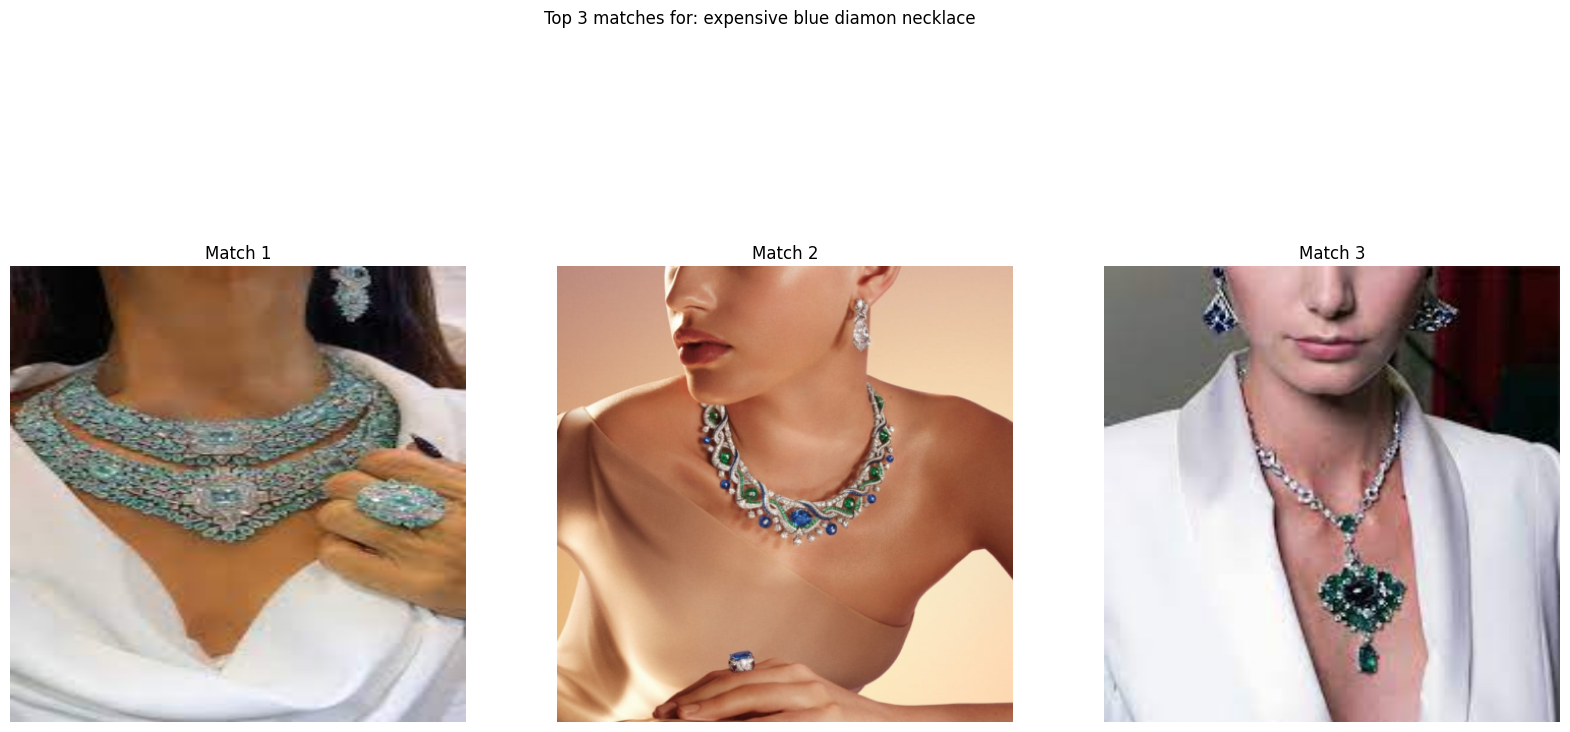

In [337]:
# Visual Search on FASHION_TRENDS INDEX 
search_image(index_name=PRODUCT_INDEX_NAME, dataset=fashion_trends_dataset, text_query="expensive blue diamon necklace",top_k=3, figSize=(20,10))

 top matches image_ids: [222, 208, 212]


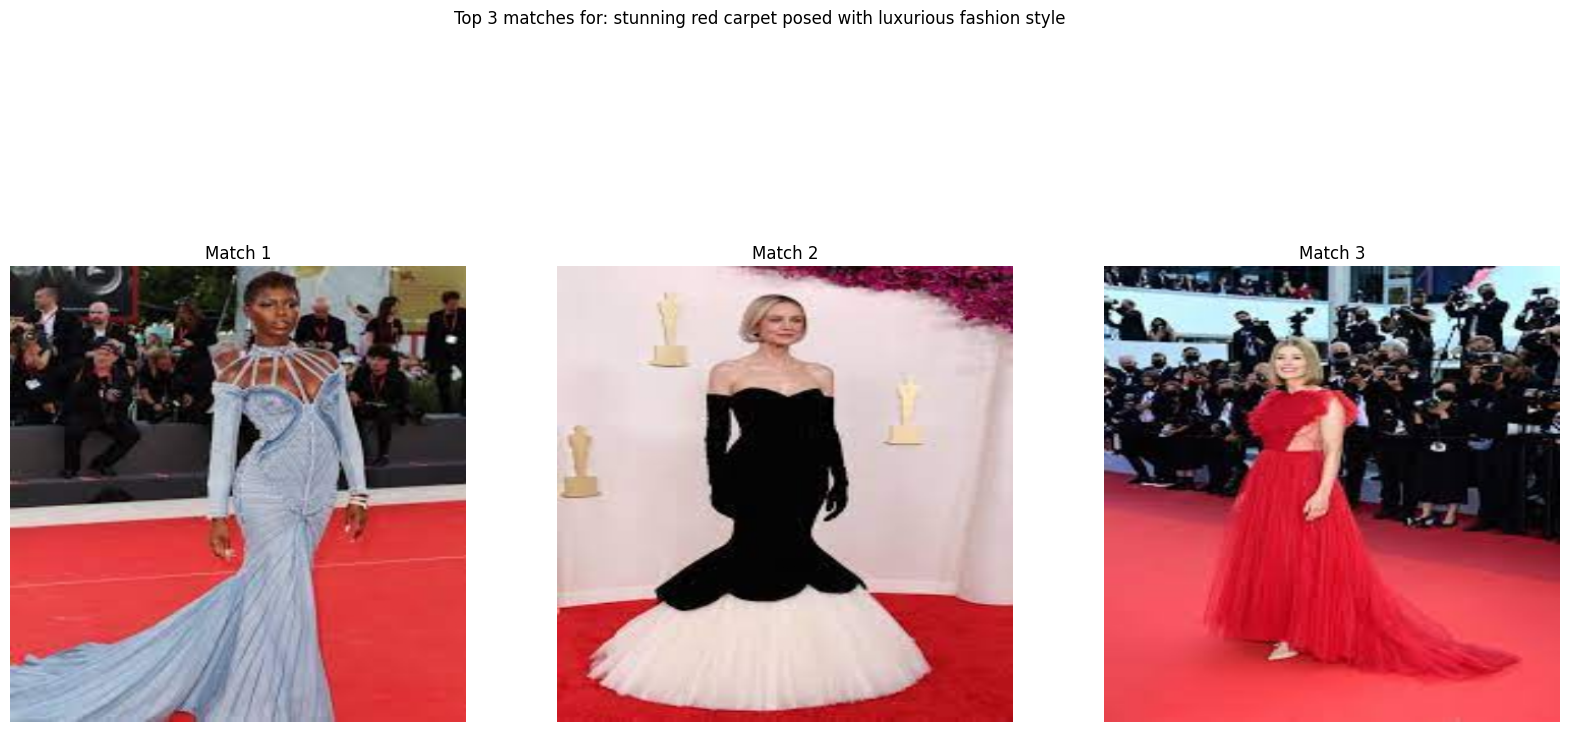

In [388]:
search_image(index_name=PRODUCT_INDEX_NAME, dataset=fashion_trends_dataset, text_query="stunning red carpet posed with luxurious fashion style",top_k=3, figSize=(20,10))

 top matches image_ids: [1, 9, 12, 13, 3]


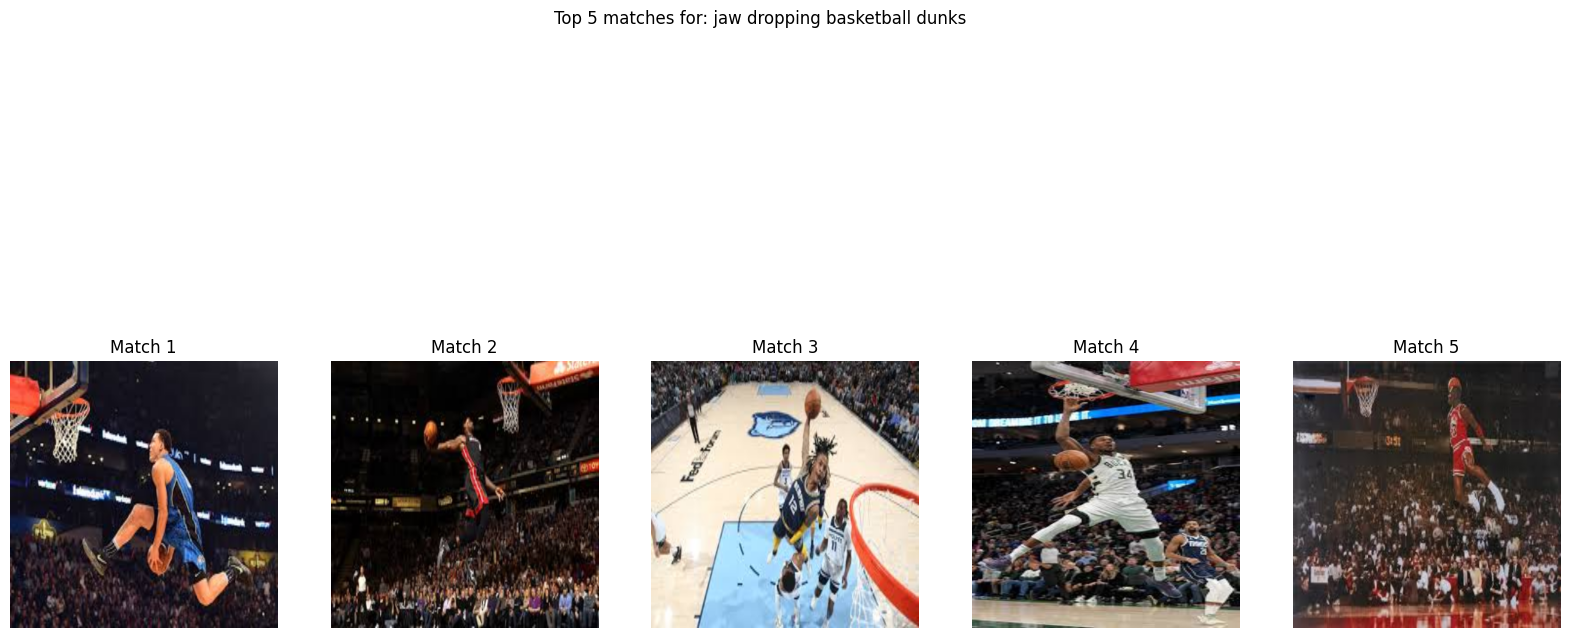

In [389]:
search_image(index_name=PRODUCT_INDEX_NAME, dataset=fashion_trends_dataset, text_query="jaw dropping basketball dunks",top_k=5, figSize=(20,10))

 top matches image_ids: [63, 147, 84, 119]


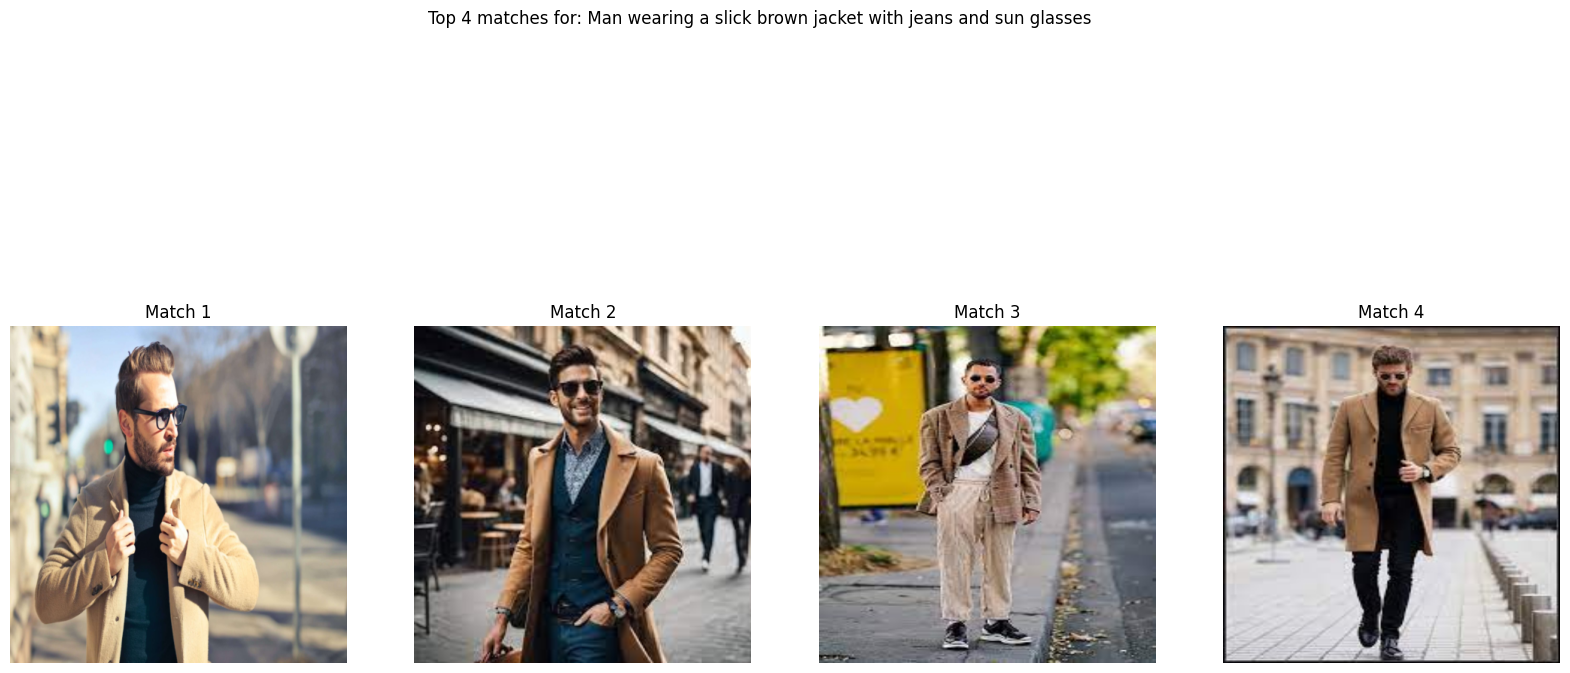

In [380]:
search_image(index_name=PRODUCT_INDEX_NAME, dataset=fashion_trends_dataset, text_query="Man wearing a slick brown jacket with jeans and sun glasses",top_k=4, figSize=(20,10))

 top matches image_ids: [1297, 9424, 1277]


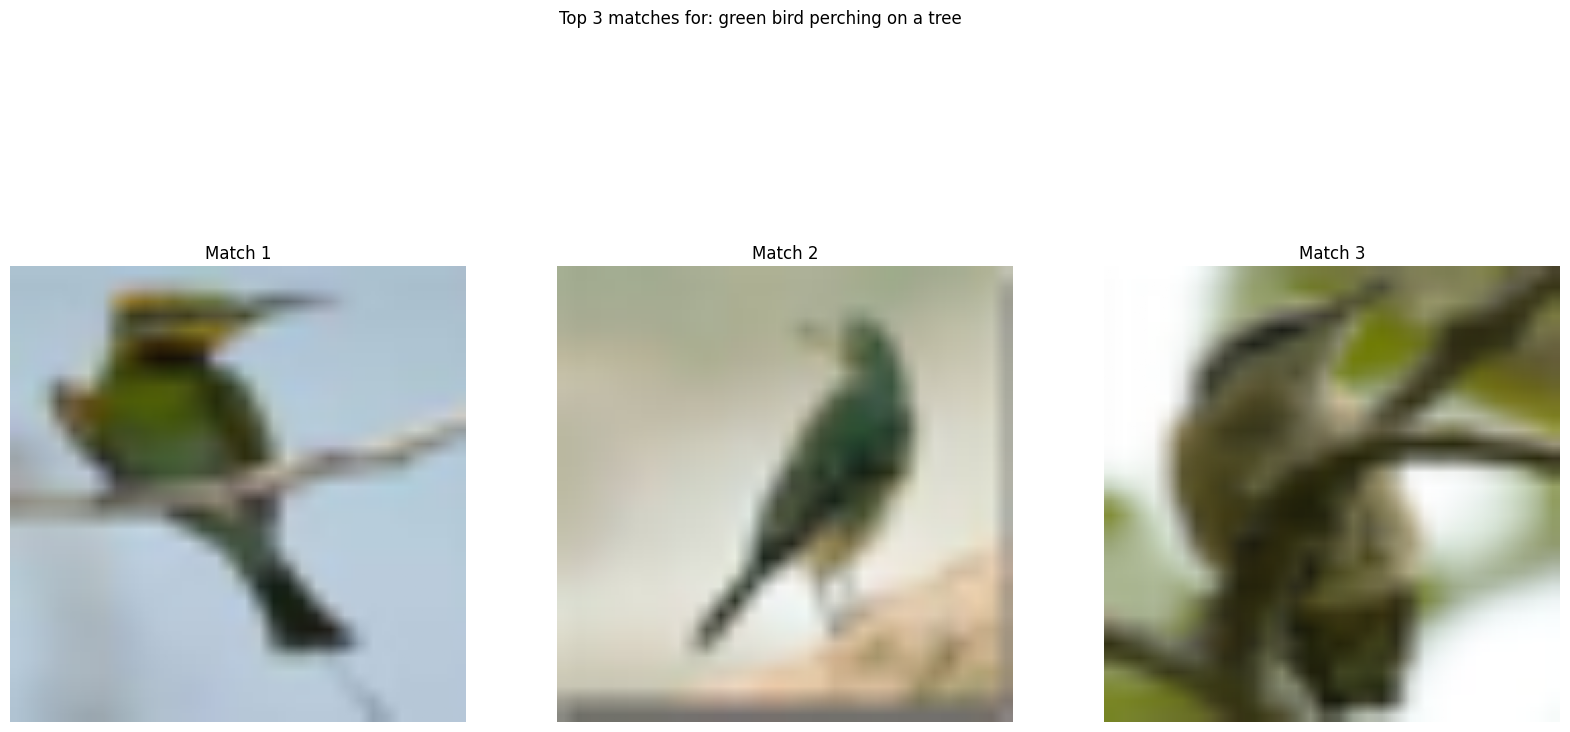

In [350]:
# Visual Search on CIFAR-10 INDEX 
search_image(index_name=CIFAR10_INDEX_NAME, dataset=cifar10_dataset, text_query="green bird perching on a tree",top_k=3, figSize=(20,10))

 top matches image_ids: [6915, 246, 4713]


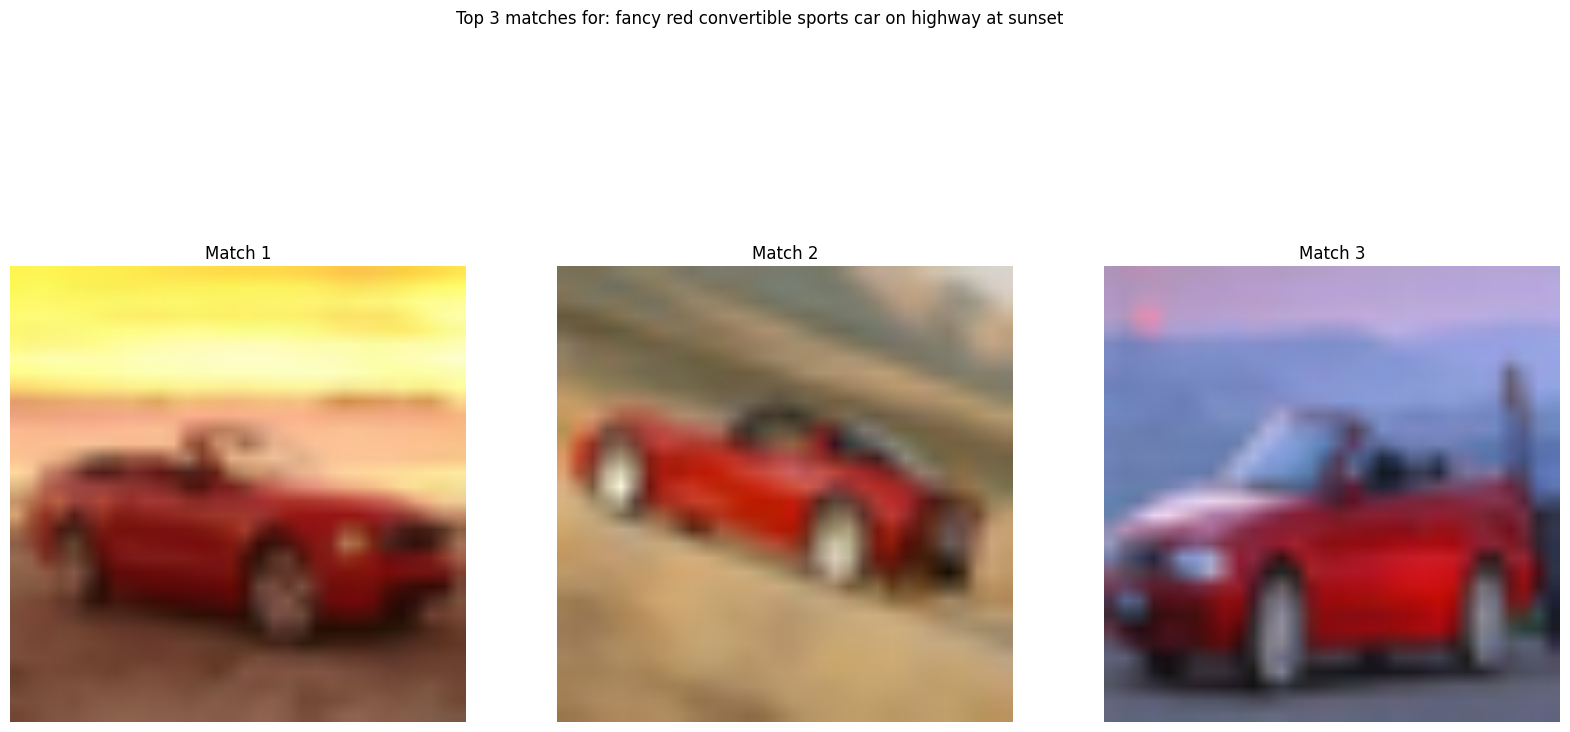

In [352]:
search_image(index_name=CIFAR10_INDEX_NAME, dataset=cifar10_dataset, text_query="fancy red convertible sports car on highway at sunset",top_k=3, figSize=(20,10))